## RAP Analysis Data - Access
Karl Schneider (kps5442@psu.edu)

In [1]:
import re, os, sys
import requests
from io import StringIO
import pandas as pd
from datetime import datetime, timedelta

### Data download
Here, I demonstrate the procedure for downloading RAP data from the NCEI archive. To avoid large download sizes, I only download the parameters of interest by specifying byte ranges in the headers of the HTTP request. We an find these byte ranges using the "index" or "inventory" file available for each grib file.

In [2]:
# Configuration
dt = datetime.utcnow()-timedelta(hours=2) # time of analysis to download
filename = 'test.grib2'

In [3]:
# Logic for sorting out url issues - get the "best" available data for RUC & RAP
def set_url(dt):
    if dt >= datetime.utcnow()-timedelta(hours=48):
        base_url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/rap/prod/rap.{yyyymmdd}/rap.t{hh}z.awp130pgrbf00'
        url_ext = '.grib2'
        idx_ext = '.grib2.idx'
    elif datetime(2020, 5, 16, 0) <= dt < datetime.utcnow()-timedelta(hours=48):
        base_url = 'https://www.ncei.noaa.gov/data/rapid-refresh/access/rap-130-13km/analysis/{yyyymm}/{yyyymmdd}/rap_130_{yyyymmdd}_{hh}00_000'
        url_ext = '.grb2'
        idx_ext = '.grb2.inv'
    elif datetime(2012, 5, 9, 0) <= dt < datetime(2020, 5, 16, 0):
        base_url = 'https://ncei.noaa.gov/data/rapid-refresh/access/historical/analysis/{yyyymm}/{yyyymmdd}/rap_130_{yyyymmdd}_{hh}00_000'
        url_ext = '.grb2'
        idx_ext = '.inv'
    elif datetime(2008, 10, 30, 0) <= dt < datetime(2012, 5, 9, 0):
        base_url = 'https://www.ncei.noaa.gov/data/rapid-refresh/access/historical/analysis/{yyyymm}/{yyyymmdd}/ruc2anl_130_{yyyymmdd}_{hh}00_000'
        url_ext = '.grb2'
        idx_ext = '.inv'
    elif datetime(2005, 1, 1, 0) <= dt < datetime(2008, 10, 30, 0):
        base_url = 'https://www.ncei.noaa.gov/data/rapid-refresh/access/historical/analysis/{yyyymm}/{yyyymmdd}/ruc2_252_{yyyymmdd}_{hh}00_000'
        url_ext = '.grb'
        idx_ext = '.inv'
    else:
        print('Data not available for this time:', dt)
    return base_url, url_ext, idx_ext

base_url, url_ext, idx_ext = set_url(dt)

In [4]:
# Format the url, get the index file in order to identify which records to download
URL = base_url.format(yyyymm=dt.strftime('%Y%m'), yyyymmdd=dt.strftime('%Y%m%d'), hh=dt.strftime('%H'))
idx = requests.get(URL+idx_ext)
if idx.status_code != 200:
    sys.exit('File not found: '+idx.url)
df = pd.read_csv(StringIO(idx.text), sep=":", names=['record','byte_start','refdate','param','level','fcst','info'])

In [5]:
df

,record,byte_start,refdate,param,level,fcst,info
0,1.0,0,d=2021110311,REFC,entire atmosphere,anl,NaN
1,2.0,67931,d=2021110311,VIS,surface,anl,NaN
2,3.0,165307,d=2021110311,REFD,1000 m above ground,anl,NaN
3,4.0,209388,d=2021110311,REFD,4000 m above ground,anl,NaN
4,5.0,239128,d=2021110311,HGT,planetary boundary layer,anl,NaN
...,...,...,...,...,...,...,...
349,301.0,16756555,d=2021110311,RHPW,entire atmosphere,anl,NaN
350,302.0,16794661,d=2021110311,SBT123,top of atmosphere,anl,NaN
351,303.0,16881153,d=2021110311,SBT124,top of atmosphere,anl,NaN
352,304.0,17016386,d=2021110311,SBT113,top of atmosphere,anl,NaN


In [6]:
# Manipulate the index file dataframe to prepare for paramater selection
df['record'] = df.loc[:, 'record'].astype(str).str.split('.', n = 1, expand = True)[0] # handle grib sub-messages
df['byte_end'] = df.drop_duplicates(subset = ['record', 'byte_start'])['byte_start'].shift(-1).reindex(index = df.index, method = 'ffill') # compute the correct ending byte
df['byte_end'].values[-1] = requests.get(URL+url_ext, stream=True).headers['Content-length'] # assign the final ending byte
df['string'] = StringIO(idx.text).readlines() # we want the entire string in order to efficiently match params
df['byte_range'] = df.loc[:, 'byte_start'].astype(str)+'-'+df.loc[:, 'byte_end'].astype(int).astype(str) # the byte range of each grib message
df = df.fillna('')

In [7]:
# Updated DataFrame
df

,record,byte_start,refdate,param,level,fcst,info,byte_end,string,byte_range
0,1,0,d=2021110311,REFC,entire atmosphere,anl,,67931.0,1:0:d=2021110311:REFC:entire atmosphere:anl:\n,0-67931
1,2,67931,d=2021110311,VIS,surface,anl,,165307.0,2:67931:d=2021110311:VIS:surface:anl:\n,67931-165307
2,3,165307,d=2021110311,REFD,1000 m above ground,anl,,209388.0,3:165307:d=2021110311:REFD:1000 m above ground...,165307-209388
3,4,209388,d=2021110311,REFD,4000 m above ground,anl,,239128.0,4:209388:d=2021110311:REFD:4000 m above ground...,209388-239128
4,5,239128,d=2021110311,HGT,planetary boundary layer,anl,,455976.0,5:239128:d=2021110311:HGT:planetary boundary l...,239128-455976
...,...,...,...,...,...,...,...,...,...,...
349,301,16756555,d=2021110311,RHPW,entire atmosphere,anl,,16794661.0,301:16756555:d=2021110311:RHPW:entire atmosphe...,16756555-16794661
350,302,16794661,d=2021110311,SBT123,top of atmosphere,anl,,16881153.0,302:16794661:d=2021110311:SBT123:top of atmosp...,16794661-16881153
351,303,16881153,d=2021110311,SBT124,top of atmosphere,anl,,17016386.0,303:16881153:d=2021110311:SBT124:top of atmosp...,16881153-17016386
352,304,17016386,d=2021110311,SBT113,top of atmosphere,anl,,17097481.0,304:17016386:d=2021110311:SBT113:top of atmosp...,17016386-17097481


In [8]:
# Copy text from this url into a regex tester in order to ensure correct matching
# I use: https://regex101.com/
idx.url

'https://nomads.ncep.noaa.gov/pub/data/nccf/com/rap/prod/rap.20211103/rap.t11z.awp130pgrbf00.grib2.idx'

In [9]:
# Match the desired parameters with a regular expression
# For simplicity, this request looks at temperature, rh, height, and u/v wind at standard pressure levels, as well as 2m temp & dew point
param_regex = '(?:(?:TMP|RH|HGT|UGRD|VGRD):(?:1000|925|850|700|500|250)\smb)|(?:(?:TMP|DPT):2\sm\s)'
df = df[df.loc[:, 'string'].str.contains(param_regex)]

In [10]:
# Updated DataFrame, only containing the parameters we want
df

,record,byte_start,refdate,param,level,fcst,info,byte_end,string,byte_range
43,38,1807944,d=2021110311,HGT,250 mb,anl,,1858751.0,38:1807944:d=2021110311:HGT:250 mb:anl:\n,1807944-1858751
44,39,1858751,d=2021110311,TMP,250 mb,anl,,1887794.0,39:1858751:d=2021110311:TMP:250 mb:anl:\n,1858751-1887794
45,40,1887794,d=2021110311,RH,250 mb,anl,,1936810.0,40:1887794:d=2021110311:RH:250 mb:anl:\n,1887794-1936810
47,42,1964200,d=2021110311,UGRD,250 mb,anl,,2036490.0,42.1:1964200:d=2021110311:UGRD:250 mb:anl:\n,1964200-2036490
48,42,1964200,d=2021110311,VGRD,250 mb,anl,,2036490.0,42.2:1964200:d=2021110311:VGRD:250 mb:anl:\n,1964200-2036490
103,88,4207700,d=2021110311,HGT,500 mb,anl,,4253300.0,88:4207700:d=2021110311:HGT:500 mb:anl:\n,4207700-4253300
104,89,4253300,d=2021110311,TMP,500 mb,anl,,4281921.0,89:4253300:d=2021110311:TMP:500 mb:anl:\n,4253300-4281921
105,90,4281921,d=2021110311,RH,500 mb,anl,,4341864.0,90:4281921:d=2021110311:RH:500 mb:anl:\n,4281921-4341864
107,92,4375117,d=2021110311,UGRD,500 mb,anl,,4447118.0,92.1:4375117:d=2021110311:UGRD:500 mb:anl:\n,4375117-4447118
108,92,4375117,d=2021110311,VGRD,500 mb,anl,,4447118.0,92.2:4375117:d=2021110311:VGRD:500 mb:anl:\n,4375117-4447118


In [11]:
# Download the data. Notice that only the desired parameters will be downloaded, specified by their byte ranges
ranges = ', '.join(df['byte_range'].unique())
response = requests.get(URL+url_ext, headers={"Range": "bytes={}".format(ranges)})
with open(filename, 'wb') as f:
    f.write(response.content)

---
### Data access and manipulation
A simple example of how to read the grib file, extract paramaters of interest, and make a quick plot with cartopy.

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from metpy.units import units

In [13]:
# Open the file as an xarray dataset
ds = xr.open_dataset('test.grib2', engine='cfgrib')

Ignoring index file 'test.grib2.923a8.idx' older than GRIB file


In [14]:
# Here's what it looks like
ds

<xarray.Dataset>
Dimensions:            (isobaricInhPa: 6, y: 337, x: 451)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
  * isobaricInhPa      (isobaricInhPa) float64 1e+03 925.0 850.0 ... 500.0 250.0
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
    heightAboveGround  float64 ...
Dimensions without coordinates: y, x
Data variables:
    gh                 (isobaricInhPa, y, x) float32 ...
    t                  (isobaricInhPa, y, x) float32 ...
    r                  (isobaricInhPa, y, x) float32 ...
    u                  (isobaricInhPa, y, x) float32 ...
    v                  (isobaricInhPa, y, x) float32 ...
    t2m                (y, x) float32 ...
    d2m                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-11-03T09:09 GRIB to CDM+CF via cfgrib-0.9.9...

In [15]:
# Pulling out some useful info for 2m temperature plot
valid_time = pd.to_datetime(ds.valid_time.values)
lat, lon = ds.latitude.values, ds.longitude.values-360.
t2m = ds['t2m'].values * units(ds['t2m'].units)
data_bbox = [lon.min(), lon.max(), lat.min(), lat.max()] # lat-lon bbox of data

In [16]:
# Here's what the t2m array looks like
t2m

Magnitude,[[298.95208740234375 298.95208740234375 298.95208740234375 ... 301.01458740234375 300.95208740234375 300.95208740234375] [298.95208740234375 298.95208740234375 298.88958740234375 ... 301.01458740234375 300.95208740234375 300.95208740234375] [298.95208740234375 298.88958740234375 298.82708740234375 ... 301.01458740234375 300.95208740234375 300.95208740234375] ... [280.26458740234375 280.45208740234375 280.57708740234375 ... 276.45208740234375 276.45208740234375 276.45208740234375] [280.38958740234375 280.51458740234375 280.57708740234375 ... 276.38958740234375 276.45208740234375 276.51458740234375] [280.45208740234375 280.57708740234375 280.57708740234375 ... 276.38958740234375 276.45208740234375 276.51458740234375]]
Units,kelvin


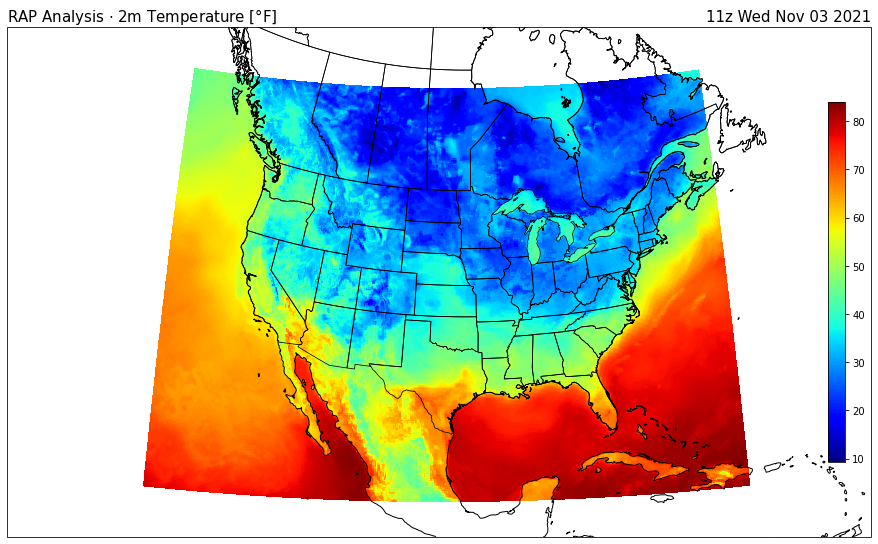

In [25]:
# Basic plot of 2m temperature
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_position([0, 0, 1, 1])
ax.set_extent(data_bbox, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.75)
mesh = ax.pcolormesh(lon, lat, t2m.to('degF').magnitude, cmap='jet', shading='auto', transform=ccrs.PlateCarree())
cax = fig.add_axes([.95, .25, 0.02, .5])
fig.colorbar(mesh, cax=cax, orientation='vertical')
ax.set_title('RAP Analysis'+r' $\cdot$ '+'2m Temperature [\N{DEGREE SIGN}F]', loc='left', fontsize=15)
ax.set_title(valid_time.strftime('%Hz %a %b %d %Y'), loc='right', fontsize=15)
plt.show()

---
### Test to see how much data is missing
The dataset is not entirely complete, so we can use the code below to zero in on specific time(s) of interest to find our if the URLs in question actually exist on the server.

In [10]:
# Change dates and interval frequency to test specific timeframes
dates = pd.date_range(start=datetime(2021,1,1,0), end=datetime.utcnow(), freq='1D')

In [11]:
for dt in dates:
    base_url, url_ext, idx_ext = set_url(dt)
    URL = base_url.format(yyyymm=dt.strftime('%Y%m'), yyyymmdd=dt.strftime('%Y%m%d'), hh=dt.strftime('%H'))
    if requests.get(URL+idx_ext).status_code != 200:
        print('Error:', URL+idx_ext)

Error: https://www.ncei.noaa.gov/data/rapid-refresh/access/rap-130-13km/analysis/202111/20211101/rap_130_20211101_0000_000.grb2.inv


There will usually be a small gap between when the operational data is available on the NOMADS server (last 2 days only) and when the data goes into the NCEI archive.